In [2]:
# === General Utilities ===
import os
import numpy as np
import pickle
import random
from math import sin, cos, sqrt, atan2, radians

# === Data Handling and Image Utilities ===
from PIL import Image
import matplotlib.pyplot as plt

# === Deep Learning (TensorFlow/Keras) ===
import tensorflow as tf

# === Visualization ===
import seaborn as sns

# === Geometry for evaluation ===
from shapely.geometry import Polygon


# Paths

In [10]:
# Path to training and testing data
TRAIN_DATA_PATH = "../DataCollection/trainData.npy"
TEST_DATA_PATH = "../DataCollection/testData.npy"

# Base folder containing triplet image folders
IMAGE_DIR = "../DataCollection/data/dataCombined"  # This should be like: 0+lat,lon/

# Grid polygons for evaluation
POLYGRID_PATH = "../DataCollection/usaPolygonGrid.pkl"


# Data Inspection



In [12]:
# Load train and test filenames
train_files = np.load(TRAIN_DATA_PATH, allow_pickle=True)
test_files = np.load(TEST_DATA_PATH, allow_pickle=True)

print(f"Train samples: {len(train_files)}")
print(f"Test samples: {len(test_files)}")

# Inspect a few examples
print("\nExample training samples:")
for f in train_files[:5]:
    print(f)

# List images inside one folder
example_folder = os.path.join(IMAGE_DIR, train_files[0])
print(f"\nImages in {example_folder}:")
print(os.listdir(example_folder))


Train samples: 4420
Test samples: 492

Example training samples:
138+48.91912085048555,-96.55263961447604
49+42.90499532534337,-112.5568108457729
194+37.7950246629556,-84.48408956747008
164+35.93170000650063,-91.05824306751238
117+30.8652340143746,-98.92535643863941

Images in ../DataCollection/data/dataCombined/138+48.91912085048555,-96.55263961447604:
['0_2024-09.jpg', '90_2024-09.jpg', '180_2024-09.jpg']


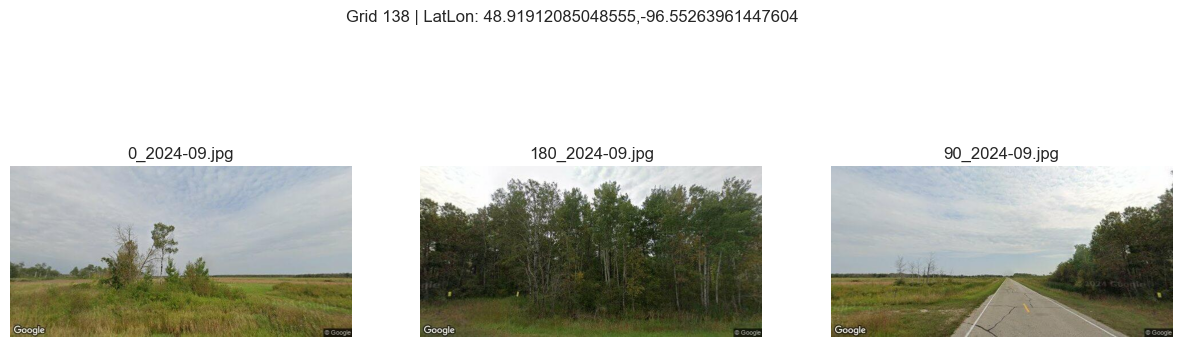

In [13]:
def show_triplet(folder_name):
    path = os.path.join(IMAGE_DIR, folder_name)
    images = sorted(os.listdir(path))  # to maintain order
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for i, img_name in enumerate(images):
        img_path = os.path.join(path, img_name)
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(img_name)
        axes[i].axis('off')
    plt.suptitle(f"Grid {folder_name.split('+')[0]} | LatLon: {folder_name.split('+')[1]}")
    plt.show()

# Try it on the first folder
show_triplet(train_files[0])


# Data Preparation

The numpy arrays from the previous notebook are not in the correct format for training. The following functions below will load the triplet images and prepare them for training. The triplet images are stored in folders named with a grid ID and latitude/longitude coordinates, e.g., "0+lat,lon/". Each folder contains three images.

In [14]:
def load_triplet_images(folder_name, target_size=(300, 600)):
    folder_path = os.path.join(IMAGE_DIR, folder_name)
    images = sorted(os.listdir(folder_path))[:3]
    triplet = []
    for img_name in images:
        img_path = os.path.join(folder_path, img_name)
        img = tf.keras.utils.load_img(img_path, target_size=target_size)
        img_array = tf.keras.utils.img_to_array(img) / 255.0  # normalize to [0,1]
        triplet.append(img_array)
    return np.stack(triplet)  # shape: (3, height, width, 3)

def prepare_batch(file_list, image_dir, input_shape=(3, 300, 600, 3), num_classes=243):
    X = []
    y = []
    for entry in file_list:
        try:
            grid_id = int(entry.split("+")[0])
            triplet = load_triplet_images(entry, target_size=input_shape[1:3])
            X.append(triplet)
            y.append(grid_id)
        except Exception as e:
            print(f"Skipping {entry} due to error: {e}")
            continue
    X = np.array(X)  # shape: (batch_size, 3, H, W, 3)
    y = tf.keras.utils.to_categorical(y, num_classes=num_classes)
    return X, y


In [15]:
# Try loading a small batch
X_batch, y_batch = prepare_batch(train_files[:10], IMAGE_DIR)

print("Batch shape:", X_batch.shape)
print("Label shape:", y_batch.shape)


Batch shape: (10, 3, 300, 600, 3)
Label shape: (10, 243)


# Defining the Model